## Data Cleaning and Data Wrangling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [3]:
file = pd.read_csv('Sept_14_Data.csv')
file = file[file.columns[:-2]]
file = file.drop([0, 1]).reset_index().drop('index', axis=1)

df = pd.DataFrame()
# Q45 - Please rate how troubled you feel about your stressful situation. Scale 0 (not troubled)-10 (very troubled)
file['Q45'] = file['Q45'].replace(['', np.inf, -np.inf], np.nan)
# Q46 - Please re-rate how troubled you feel about your stressful situation. Scale 0 (not troubled)-10 (very troubled)
file['Q46'] = file['Q46'].replace(['', np.inf, -np.inf], np.nan)


df["prestress"] = file["Q45"].fillna(file["Q31"]).replace(['', np.inf, -np.inf, np.nan], -99)
df["poststress"] = file["Q46"].fillna(file["Q32"]).replace(['', np.inf, -np.inf, np.nan], -99)

# Q109 - How old are you? Values allowed 18 to 100
df["age"] = file['Q109'].replace(['', np.inf, -np.inf, np.nan], -99)
# Q110 - How would you describe your gender identity? 1-Male, 2-Female, 4-Other
df["gender"] = file['Q110'].replace(['', np.inf, -np.inf, np.nan], -99)
# Q107 - Have you sought treatment from a professional for any of the following? 8 options with user choice of 0 to 8 options
df["treatment"] = file['Q107']
# Q129 - How much experience have you had previously with Cognitive Behavioral Therapy Techniques? 4 options - single answer
# NOTE: Not Available in CSV
# df["CBTself"] = file['Q129'].replace('',np.nan)
# Q130 - How many therapy/counseling sessions have you been to (using Cognitive Behavioral Therapy techniques)? 4 options
# NOTE: Not Available in CSV
# df["CBTsess"] = file['Q130'].replace('',np.nan)

df["poststress"] = df["poststress"].astype(int)
df["prestress"] = df["prestress"].astype(int)
df["age"] = df["age"].astype(int)
df["gender"] = df["gender"].astype('category')

# Reward - Change in stress level
df['change'] = df['prestress'] - df['poststress']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 6 columns):
prestress     531 non-null int64
poststress    531 non-null int64
age           531 non-null int64
gender        531 non-null category
treatment     331 non-null object
change        531 non-null int64
dtypes: category(1), int64(4), object(1)
memory usage: 21.5+ KB


In [4]:
# Remove all values with -99 which indicates that the user hasn't filled the field
df = df.replace(-99,np.nan).replace('-99',np.nan)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,prestress,poststress,age,gender,treatment,change
0,8.0,7.0,38.0,1.0,3,1
1,7.0,4.0,59.0,2.0,"1,2,8",3
2,8.0,6.0,31.0,1.0,2,2
3,9.0,8.0,29.0,1.0,"1,2,8",1
4,6.0,6.0,34.0,1.0,6,0


In [5]:
# Creating different categorical variables for the treatments the user has previously recieved
df.treatment = df.treatment.astype(str)
treat_dict = {1:"Anxiety_disorders", 2:"Depression", 3:"Bipolar_disorder", 4:"Personality_disorders", 5:"Psychosis",
              6:"Schizoaffective_disorder", 7:"Schizophrenia", 8:"Stress"}
for val, treat in treat_dict.items():
    df[treat] = np.where(df.treatment.str.contains(str(val)), 1, 0)
df.head()

,prestress,poststress,age,gender,treatment,change,Anxiety_disorders,Depression,Bipolar_disorder,Personality_disorders,Psychosis,Schizoaffective_disorder,Schizophrenia,Stress
0,8.0,7.0,38.0,1.0,3,1,0,0,1,0,0,0,0,0
1,7.0,4.0,59.0,2.0,"1,2,8",3,1,1,0,0,0,0,0,1
2,8.0,6.0,31.0,1.0,2,2,0,1,0,0,0,0,0,0
3,9.0,8.0,29.0,1.0,"1,2,8",1,1,1,0,0,0,0,0,1
4,6.0,6.0,34.0,1.0,6,0,0,0,0,0,0,1,0,0


## Initial Analysis with only Age and Gender

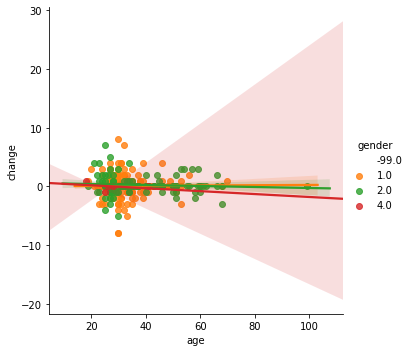

In [6]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.lmplot(y = 'change', x = 'age', hue='gender', data = df)

In [7]:
import statsmodels.formula.api as smf
model = smf.ols("change ~ age + C(gender)", data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 change   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.2859
Date:                Wed, 20 Nov 2019   Prob (F-statistic):              0.836
Time:                        13:39:21   Log-Likelihood:                -651.86
No. Observations:                 328   AIC:                             1312.
Df Residuals:                     324   BIC:                             1327.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2114      0.312  

## Linear Regression with all Contextual Variables

In [36]:
model = smf.ols("change ~ age + C(gender) + C(Anxiety_disorders) + C(Depression) + C(Bipolar_disorder) + C(Personality_disorders) + C(Psychosis) + C(Schizoaffective_disorder) + C(Schizophrenia) + C(Stress)", \
                data = df).fit()
print(model.summary())

                                         0         1
Intercept                        -0.822200  0.595697
C(gender)[T.1.0]                 -0.325063  0.595176
C(gender)[T.2.0]                 -0.359269  0.695353
C(gender)[T.4.0]                 -1.629992  0.797293
C(Anxiety_disorders)[T.1]         0.213833  1.048648
C(Depression)[T.1]               -0.303302  0.511347
C(Bipolar_disorder)[T.1]         -0.835025  0.751469
C(Personality_disorders)[T.1]    -1.040581  0.394882
C(Psychosis)[T.1]                -0.252951  1.240475
C(Schizoaffective_disorder)[T.1] -2.797680  0.006765
C(Schizophrenia)[T.1]            -1.713546  1.453135
C(Stress)[T.1]                   -0.467458  0.361994
age                              -0.021677  0.016018
                            OLS Regression Results                            
Dep. Variable:                 change   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.024
Method:              

In [47]:
model = smf.ols("change ~ age + C(Anxiety_disorders) + C(Stress)", \
                data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 change   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     3.306
Date:                Wed, 20 Nov 2019   Prob (F-statistic):             0.0205
Time:                        14:15:32   Log-Likelihood:                -647.35
No. Observations:                 328   AIC:                             1303.
Df Residuals:                     324   BIC:                             1318.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

### Confidence Interval


In [48]:
print(model.conf_int())

                                  0         1
Intercept                 -0.645879  0.688384
C(Anxiety_disorders)[T.1]  0.231042  1.024922
C(Stress)[T.1]            -0.433708  0.334162
age                       -0.020040  0.015989


## TODO: Exploratory Factor Analysis